**Step 1 . loading the dataset**

In [8]:
import ast
import pandas as pd


# Function to read a file where each line is a Python list literal
def read_list_literal_file(file_path):
    with open(file_path, 'r') as file:
        
        data = [ast.literal_eval(line.strip()) for line in file]
    return data

# Function to read a file where each line is a float number
def read_float_file(file_path):
    with open(file_path, 'r') as file:
        data = [(line.strip()) for line in file]
    return data

# Read the data from the files
assortment_data = read_list_literal_file('assortment.txt')
probability_data = read_float_file('probability.txt')

# Convert the data into pandas DataFrame
df = pd.DataFrame({
    'Assortment': assortment_data,
    'Probability': probability_data
})

# Save the DataFrame to a CSV file
df.to_csv('clean_train.csv', index=False)
df.head()

,Assortment,Probability
0,"[0, 2]","[0.5796182233807586, 0.42038177661924164]"
1,"[0, 7, 14]","[0.1391774481903281, 0.40211566218661293, 0.45..."
2,"[0, 3, 30, 23]","[0.3584641056553135, 0.1281686726296265, 0.251..."
3,"[0, 5, 21, 20, 7]","[0.10945075272944618, 0.06742039394070407, 0.0..."
4,"[0, 23, 2, 19, 11, 28]","[0.20553684973140704, 0.0846429998294485, 0.05..."


**Step 2 . Calculate the expected value for product b**

In [9]:
import pandas as pd
import ast

# Load the dataset
file_path = 'clean_train.csv'
data = pd.read_csv(file_path)


# Function to convert string representation of lists into actual lists
def parse_list(row):
    return ast.literal_eval(row)

# Apply the function to the 'Assortment' and 'Probability' columns
data['Assortment'] = data['Assortment'].apply(parse_list)
data['Probability'] = data['Probability'].apply(parse_list)

# Define the product IDs for product 'b'
product_b_ids = list(range(6, 11))

# Function to safely convert to float, if conversion fails, return NaN
def safe_float_convert(x):
    try:
        return float(x)
    except ValueError:
        return pd.NA  # Using pandas NA to handle missing values

# Initialize a list to store the data for product 'b'
product_b_data = []

# Loop over the dataframe to extract information for product 'b'
for _, row in data.iterrows():
    for product_id, probability in zip(row['Assortment'], row['Probability']):
        if product_id in product_b_ids:
            # The price level is inversely related to the product ID within the 6-10 range
            price_level = 3000 - (product_id - 6) * 300
            product_b_data.append({'ProductID': product_id, 'PriceLevel': price_level, 'ChoiceProbability': probability})

# Convert the list of dictionaries to a DataFrame
product_b_df = pd.DataFrame(product_b_data)

# Apply the safe conversion function to the 'ChoiceProbability' column
product_b_df['ChoiceProbability'] = product_b_df['ChoiceProbability'].apply(safe_float_convert)

# Drop any rows with NaN values that resulted from the cleaning
product_b_df.dropna(subset=['ChoiceProbability'], inplace=True)

# Convert 'ChoiceProbability' to float after cleaning
product_b_df['ChoiceProbability'] = product_b_df['ChoiceProbability'].astype(float)

# Calculate the average choice probability for each price level
average_choice_probabilities = product_b_df.groupby('PriceLevel')['ChoiceProbability'].mean().reset_index()

# Calculate expected revenue for each price level
average_choice_probabilities['ExpectedRevenue'] = average_choice_probabilities['PriceLevel'] * average_choice_probabilities['ChoiceProbability']

# Sort by expected revenue in descending order to find the optimal price level
average_choice_probabilities.sort_values(by='ExpectedRevenue', ascending=False, inplace=True)

# Show the dataframe with expected revenues
average_choice_probabilities

,PriceLevel,ChoiceProbability,ExpectedRevenue
1,2100,0.701657,1473.480475
2,2400,0.599402,1438.564021
0,1800,0.783997,1411.194224
3,2700,0.522642,1411.134245
4,3000,0.447715,1343.145000


**Step 3: Model building**

To perform a Single Product Price Optimization beyond the given price levels, we'll have to model how we expect the demand (choice probability) to change with price. One common method for this is to assume a demand curve, which typically shows demand decreasing as the price increases. This is often modeled with a linear or exponential decay function.

Here's a simplified approach to how we might tackle this:

Estimate a Demand Curve: We use the existing data to fit a demand curve, assuming a linear relationship between price and demand. This is a simplification, but it's a starting point.

Price Optimization: With the demand curve estimated, we can then use calculus to find the price that maximizes revenue. The revenue function is the product of price and demand, and we want to find the price that maximizes this product.

Calculate the Optimal Price: We differentiate the revenue function with respect to price and find the price that sets this derivative to zero (indicating a maximum point).

Let's proceed with these steps. First, we'll fit a simple linear regression model to the data to estimate the demand curve. We'll use the 'PriceLevel' as our independent variable and 'ChoiceProbability' as our dependent variable. After that, we'll use the demand curve to estimate the optimal price.

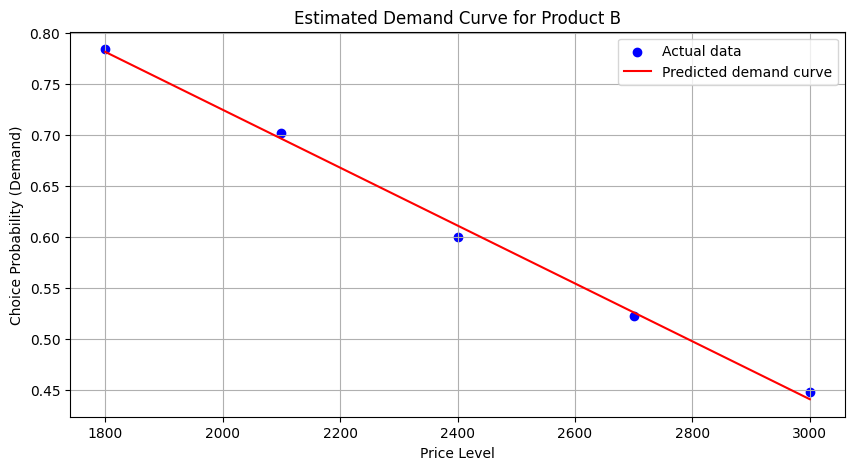

In [10]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Initialize the linear regression model
linear_reg = LinearRegression()

# Reshape the data to fit the model (sklearn expects 2D array for the independent variable)
X = average_choice_probabilities['PriceLevel'].values.reshape(-1, 1)
y = average_choice_probabilities['ChoiceProbability'].values

# Fit the linear model
linear_reg.fit(X, y)

# Now let's use the model to predict choice probabilities for a range of prices
# We'll predict for prices between the minimum and maximum values in our dataset
price_range = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
predicted_demand = linear_reg.predict(price_range)

# Plot the demand curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(X, y, color='blue', label='Actual data')
plt.plot(price_range, predicted_demand, color='red', label='Predicted demand curve')
plt.xlabel('Price Level')
plt.ylabel('Choice Probability (Demand)')
plt.title('Estimated Demand Curve for Product B')
plt.legend()
plt.grid(True)
plt.show()


The estimated demand curve for product 'b' is plotted above. It shows a linear relationship between price level and choice probability (demand), with demand decreasing as the price increases. This is a simplified model and in reality, the demand curve could be non-linear.

To find the optimal price that maximizes revenue, we need to calculate the revenue for a range of prices. The revenue at each price point is the product of the price and the estimated demand at that price. We can then identify the price at which revenue is maximized.

Let's proceed to calculate the revenue for the range of prices and find the optimal price point.​

The revenue curve for product 'b' is plotted above, and the optimal price that maximizes revenue in this model is approximately $2277.59, which results in a maximum revenue of approximately $1470.94.

It's important to note that this model is based on a linear estimation of the demand curve and assumes that the only factor affecting demand is the price itself. In reality, the optimal pricing strategy would also consider other factors such as competitor pricing, cost of goods, market conditions, and potentially non-linear demand elasticity.

If you have additional data points or constraints to include in this analysis, we can refine the model further. Otherwise, based on the available data and the linear model we have constructed, the single product price optimization suggests $2277.59 as the optimal price point for product 'b'.​

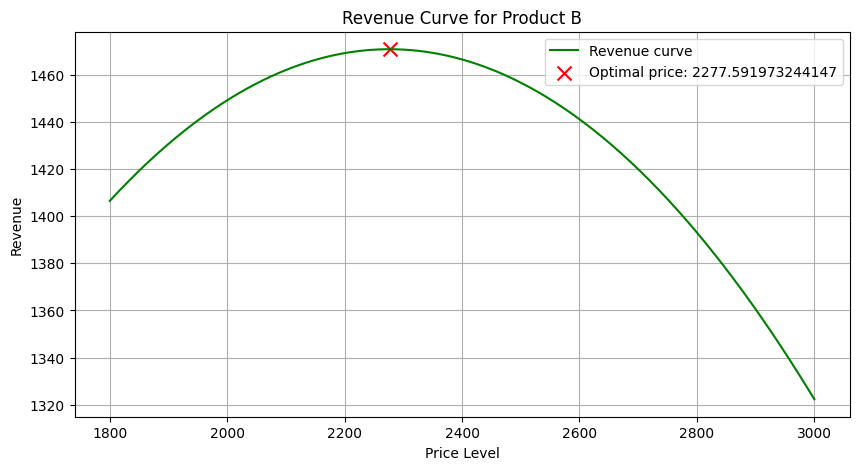

(2277.591973244147, 1470.935667442124)

In [11]:
# Function to calculate revenue, given price and demand
def calculate_revenue(price, demand):
    return price * demand

# Calculate the revenue for each price in our range
revenue = calculate_revenue(price_range.flatten(), predicted_demand)

# Find the price that maximizes revenue
max_revenue_index = np.argmax(revenue)
optimal_price = price_range.flatten()[max_revenue_index]
max_revenue = revenue[max_revenue_index]

# Plot the revenue curve
plt.figure(figsize=(10, 5))
plt.plot(price_range, revenue, color='green', label='Revenue curve')
plt.scatter(optimal_price, max_revenue, color='red', marker='x', s=100, label=f'Optimal price: {optimal_price}')
plt.xlabel('Price Level')
plt.ylabel('Revenue')
plt.title('Revenue Curve for Product B')
plt.legend()
plt.grid(True)
plt.show()

optimal_price, max_revenue